In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.5 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()


KeyboardInterrupt: 

In [ ]:
import os
os.listdir()


['.config',
 'B08.jp2',
 'MTL.txt',
 'B10.TIF',
 'B04.jp2',
 'B03.jp2',
 'sample_data']

**NVDI, NDWI, LST AND Drought MAP of LAHORE**

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pywt
import re
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from skimage.transform import resize
import matplotlib.colors as mcolors

# Define window (crop to reduce RAM usage)
window = rasterio.windows.Window(0, 0, 1000, 1000)

# Load Sentinel-2 bands
with rasterio.open("B04.jp2") as red_src:
    red = red_src.read(1, window=window).astype(float)

with rasterio.open("B08.jp2") as nir_src:
    nir = nir_src.read(1, window=window).astype(float)

with rasterio.open("B03.jp2") as green_src:
    green = green_src.read(1, window=window).astype(float)

# NDVI and NDWI
ndvi = (nir - red) / (nir + red + 1e-10)
ndwi = (nir - green) / (nir + green + 1e-10)

# Load Landsat Band 10 (thermal) and metadata
with rasterio.open("B10.TIF") as src:
    band10 = src.read(1, window=window).astype(float)

with open("MTL.txt", 'r') as f:
    mtl = f.read()

def get_const(key):
    match = re.search(f"{key}\s=\s([\d\.E+-]+)", mtl)
    return float(match.group(1)) if match else None

ML = get_const("RADIANCE_MULT_BAND_10")
AL = get_const("RADIANCE_ADD_BAND_10")
K1 = get_const("K1_CONSTANT_BAND_10")
K2 = get_const("K2_CONSTANT_BAND_10")

radiance = ML * band10 + AL
bt = K2 / np.log((K1 / radiance) + 1)
lst_celsius = bt - 273.15

# Define drought classification function
def predict_drought(ndvi, ndwi, lst):
    drought = np.zeros_like(ndvi)
    drought[(ndvi >= 0.3) & (ndvi < 0.5)] = 1
    drought[ndvi < 0.3] = 2
    return drought

# Apply classifier
drought_map = predict_drought(ndvi, ndwi, lst_celsius)

# Texture features
ndvi_norm = (ndvi - np.nanmin(ndvi)) / (np.nanmax(ndvi) - np.nanmin(ndvi))
ndvi_small = resize(ndvi_norm, (512, 512), mode='reflect')
ndvi_ubyte = img_as_ubyte(ndvi_small)
glcm = graycomatrix(ndvi_ubyte, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')[0, 0]
coeffs2 = pywt.dwt2(ndvi_small, 'haar')
cA, (cH, cV, cD) = coeffs2
wavelet_energy = np.sum(cA**2) + np.sum(cH**2) + np.sum(cV**2) + np.sum(cD**2)

# Custom color map for drought
drought_cmap = mcolors.ListedColormap(['green', 'yellow', 'red'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, drought_cmap.N)

# Plot all outputs with colorbars
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# NDVI
ndvi_img = axs[0, 0].imshow(ndvi, cmap='YlGn')
axs[0, 0].set_title("NDVI (Vegetation Health)")
plt.colorbar(ndvi_img, ax=axs[0, 0], orientation='vertical', label='NDVI')

# NDWI
ndwi_img = axs[0, 1].imshow(ndwi, cmap='Blues')
axs[0, 1].set_title("NDWI (Water Content)")
plt.colorbar(ndwi_img, ax=axs[0, 1], orientation='vertical', label='NDWI')

# LST
lst_img = axs[1, 0].imshow(lst_celsius, cmap='inferno')
axs[1, 0].set_title("LST (Land Surface Temp °C)")
plt.colorbar(lst_img, ax=axs[1, 0], orientation='vertical', label='LST (°C)')

# Drought map
drought_img = axs[1, 1].imshow(drought_map, cmap=drought_cmap, norm=norm)
axs[1, 1].set_title("Drought Risk Map\n0=Normal, 1=Moderate, 2=Severe")
cbar = plt.colorbar(drought_img, ax=axs[1, 1], ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(['Normal', 'Moderate', 'Severe'])

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print texture metrics
print(f"GLCM Contrast: {contrast:.2f}")
print(f"Wavelet Energy: {wavelet_energy:.2f}")


ModuleNotFoundError: No module named 'rasterio'

**DROUGHT RISK MAP NDMC ACTUAL DATA**

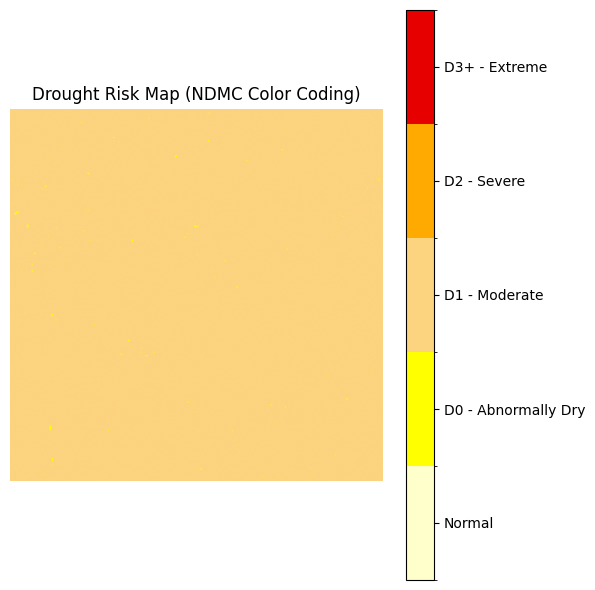

In [ ]:
import matplotlib.colors as mcolors

# NDMC color scheme: 0=Normal, 1=D0, 2=D1, 3=D2, 4=D3+
ndmc_colors = mcolors.ListedColormap([
    '#ffffcc',  # Normal
    '#ffff00',  # D0
    '#fcd37f',  # D1
    '#ffaa00',  # D2
    '#e60000',  # D3
])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, ndmc_colors.N)

# Plot drought classification with NDMC colors
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(drought_map, cmap=ndmc_colors, norm=norm)
cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
cbar.ax.set_yticklabels([
    'Normal', 'D0 - Abnormally Dry',
    'D1 - Moderate', 'D2 - Severe', 'D3+ - Extreme'
])
ax.set_title("Drought Risk Map (NDMC Color Coding)")
ax.axis('off')
plt.tight_layout()
plt.show()
def predict_drought_ndmc(ndvi):
    drought = np.zeros_like(ndvi)
    drought[(ndvi < 0.4) & (ndvi >= 0.3)] = 1  # D0
    drought[(ndvi < 0.3) & (ndvi >= 0.2)] = 2  # D1
    drought[(ndvi < 0.2) & (ndvi >= 0.1)] = 3  # D2
    drought[(ndvi < 0.1)] = 4                 # D3+
    return drought


Generating fake NDVI data...
NDVI data saved in /ndvi_data folder.
Building dummy deep learning model...
Dummy model saved as cv_drought_vit.h5
Loading NDVI stack...
Loading model and predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Visualizing prediction...


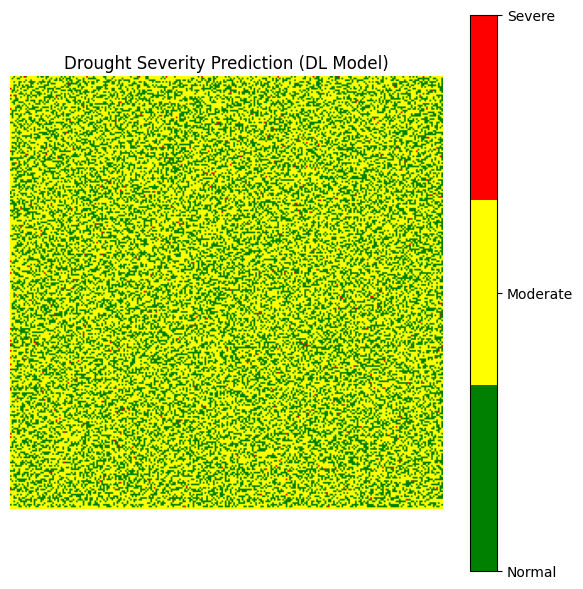

Done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
import os

# ============================
# STEP 1: Generate Fake NDVI Data (6 months)
# ============================
print("Generating fake NDVI data...")
height, width, months = 256, 256, 6
os.makedirs("ndvi_data", exist_ok=True)

for i, month in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']):
    fake_ndvi = np.random.uniform(-0.2, 0.6, size=(height, width)).astype(np.float32)
    np.save(f'ndvi_data/ndvi_{month}.npy', fake_ndvi)
print("NDVI data saved in /ndvi_data folder.")

# ============================
# STEP 2: Build Dummy Model and Save as .h5
# ============================
print("Building dummy deep learning model...")
model = models.Sequential([
    layers.Input(shape=(256, 256, 6)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(3, (1, 1), activation='softmax', padding='same')  # Output: 3 classes
])
model.save('cv_drought_vit.h5')
print("Dummy model saved as cv_drought_vit.h5")

# ============================
# STEP 3: Load NDVI Stack
# ============================
print("Loading NDVI stack...")
ndvi_stack = []
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']:
    ndvi = np.load(f'ndvi_data/ndvi_{month}.npy')
    ndvi_stack.append(ndvi)
img_stack = np.stack(ndvi_stack, axis=-1)  # Shape: [256, 256, 6]

# Normalize between 0–1
img_stack = (img_stack - np.min(img_stack)) / (np.max(img_stack) - np.min(img_stack))

# Add batch dimension
img_stack = np.expand_dims(img_stack, axis=0)  # Shape: [1, 256, 256, 6]

# ============================
# STEP 4: Load Model and Predict
# ============================
print("Loading model and predicting...")
model = load_model('cv_drought_vit.h5')
pred = model.predict(img_stack)  # Shape: [1, 256, 256, 3]
drought_map = np.argmax(pred[0], axis=-1)  # Shape: [256, 256]

# ============================
# STEP 5: Visualization
# ============================
print("Visualizing prediction...")
colors = ['green', 'yellow', 'red']  # 0=Normal, 1=Moderate, 2=Severe
cmap = plt.matplotlib.colors.ListedColormap(colors)

plt.figure(figsize=(6, 6))
plt.imshow(drought_map, cmap=cmap)
plt.title("Drought Severity Prediction (DL Model)")
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Normal', 'Moderate', 'Severe'])
plt.axis('off')
plt.tight_layout()
plt.savefig("drought_map.png", dpi=150)
plt.show()

print("Done.")


**CREATION OF DUMMY DATA**

In [ ]:
import numpy as np
import os

# Create directory if not exists
os.makedirs("ndvi_data", exist_ok=True)

# Generate fake NDVI values for 6 months
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']:
    fake_ndvi = np.random.uniform(-0.2, 0.6, size=(256, 256)).astype(np.float32)
    np.save(f'ndvi_data/ndvi_{month}.npy', fake_ndvi)

print("✅ NDVI data generated and saved in 'ndvi_data' folder.")


✅ NDVI data generated and saved in 'ndvi_data' folder.


In [ ]:
from tensorflow.keras import models, layers

# Dummy model that accepts NDVI stack and predicts 3-class output
model = models.Sequential([
    layers.Input(shape=(256, 256, 6)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(3, (1, 1), activation='softmax', padding='same')
])

# Save the model
model.save('cv_drought_vit.h5')
print("✅ Dummy model saved as cv_drought_vit.h5")


✅ Dummy model saved as cv_drought_vit.h5


**PREDICTION OF DUMMY DATA**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Pixel-wise Accuracy: 33.31%
Precision: 0.2151
Recall:    0.3331
F1 Score:  0.1684


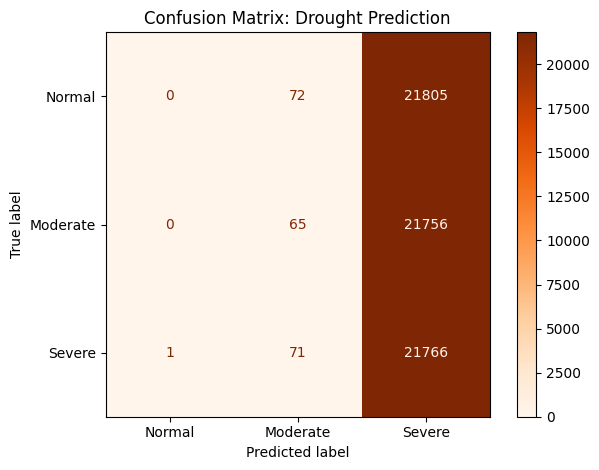

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import os

# ============================
# STEP 1: Load NDVI Stack (6 months)
# ============================
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
ndvi_stack = [np.load(f'ndvi_data/ndvi_{m}.npy') for m in months]
img_stack = np.stack(ndvi_stack, axis=-1)  # Shape: [256, 256, 6]

# Normalize
img_stack = (img_stack - np.min(img_stack)) / (np.max(img_stack) - np.min(img_stack))
img_stack = np.expand_dims(img_stack, axis=0)  # [1, 256, 256, 6]

# ============================
# STEP 2: Load Trained Model
# ============================
model = load_model('cv_drought_vit.h5')

# ============================
# STEP 3: Predict
# ============================
pred = model.predict(img_stack)  # [1, 256, 256, 3]
drought_pred = np.argmax(pred[0], axis=-1)  # [256, 256]

# ============================
# STEP 4: Load Ground Truth Labels
# ============================
# Replace this with your actual label data
# For demo: simulate with random labels
true_labels = np.random.randint(0, 3, size=(256, 256))  # [256, 256]

# ============================
# STEP 5: Flatten for Metrics
# ============================
y_true = true_labels.flatten()
y_pred = drought_pred.flatten()

# ============================
# STEP 6: Evaluate
# ============================
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Pixel-wise Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ============================
# STEP 7: Confusion Matrix
# ============================
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Moderate', 'Severe'])
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix: Drought Prediction")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()
